# Project 4: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 18.9MB 24kB/s  eta 0:00:01 0% |                                | 20kB 2.3MB/s eta 0:00:09    22% |███████▎                        | 4.3MB 39.0MB/s eta 0:00:01    32% |██████████▎                     | 6.1MB 37.3MB/s eta 0:00:01    50% |████████████████▎               | 9.6MB 38.2MB/s eta 0:00:01    87% |████████████████████████████    | 16.5MB 36.6MB/s eta 0:00:01
    98% |███████████████████████████████▋| 870kB 13.5MB/s eta 0:00:01    100% |████████████████████████████████| 880kB 521kB/s 
    100% |████████████████████████████████| 17.0MB 26kB/s  eta 0:00:01   17% |█████▊                          | 3.0MB 34.0MB/s eta 0:00:01    27% |████████▉                       | 4.7MB 34.5MB/s eta 0:00:01    36% |███████████▉                    | 6.3MB 32.2MB/s eta 0:00:01    54% |█████████████████▍              | 9.3MB 33.4MB/s eta 0:00:01    80% |█████████████████████████▋      | 13.6MB 33.8MB/s eta 0:00:01
    100% |████████████████████████████████| 7

### Load Packages

In [99]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_tests
import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [98]:
!pip install numpy==1.14.5

    100% |████████████████████████████████| 12.2MB 38kB/s  eta 0:00:01   19% |██████▎                         | 2.4MB 27.9MB/s eta 0:00:01    47% |███████████████▎                | 5.8MB 39.0MB/s eta 0:00:01
  Found existing installation: numpy 1.15.0
    Uninstalling numpy-1.15.0:
      Successfully uninstalled numpy-1.15.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [5]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


## Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [6]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [7]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers[:10]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI])]

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [8]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [9]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [10]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns.head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.02670202,0.00714639,0.00000000,0.00199434,0.00416541,0.00164769,-0.00712736,-0.00581846,...,-0.00183775,-0.00561865,0.00546091,-0.00404361,-0.01395259,0.00000000,0.01245693,-0.00018145,-0.01045802,0.00000000
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.00743543,0.01885158,0.00000000,-0.00571429,-0.00889600,-0.00885384,0.02871411,0.00292626,...,0.00094687,0.00781438,-0.00608100,0.01046585,0.00973303,0.00000000,0.00143979,0.00778351,-0.01794496,0.00000000
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00592730,-0.00236744,0.00000000,0.00978303,-0.00206747,0.01371668,0.00060680,0.00875316,...,0.00131385,0.01017933,0.00744242,0.00735141,0.00611644,0.00000000,-0.00646974,0.03567570,0.00746728,0.00000000
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.01338721,0.00813289,0.00000000,-0.00597922,-0.00101061,0.02296913,0.01795027,0.00025710,...,0.00498609,0.01566621,0.01176334,0.02718194,0.00438630,0.00000000,0.00263106,0.01474083,-0.01190269,0.00000000
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00303109,0.00365656,0.00000000,0.01492537,-0.00445119,-0.00040011,-0.00571905,-0.00501221,...,0.03049927,-0.00321668,0.00169383,0.00054651,-0.01823475,0.00000000,-0.00508430,-0.00466453,-0.00917796,0.00000000


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [11]:
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    model = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    model.fit(returns)
    
    return model


project_tests.test_fit_pca(fit_pca)

Tests Passed


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [12]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_


array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ..., 
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

Let's also look at the PCA's percent of variance explained by each factor

<Container object of 20 artists>

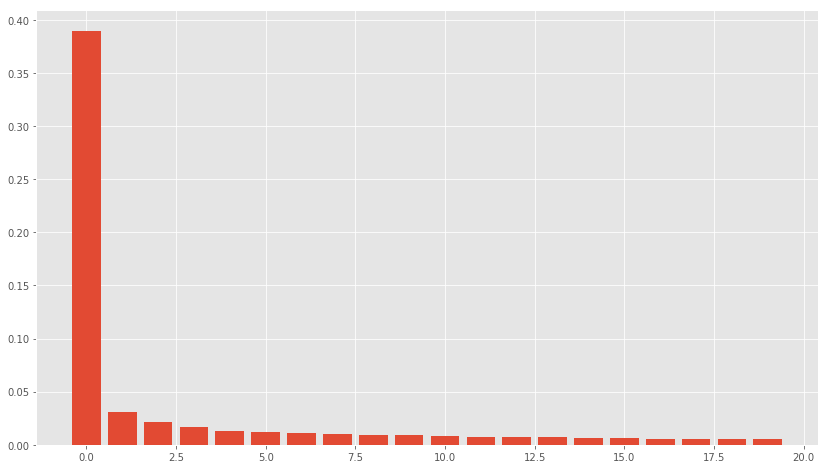

In [13]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [14]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    
    
    return pd.DataFrame(
                        data=pca.components_.T, 
                        index=factor_beta_indices, 
                        columns=factor_beta_columns
                        )


project_tests.test_factor_betas(factor_betas)

Tests Passed


### View Data
Let's view the factor betas from this model.

In [15]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.04316847,0.01955111,-0.00993375,0.01054038,-0.01819821,0.01074517,0.00112915,0.03973914,-0.01380519,0.01273651,-0.02384028,-0.00141663,0.02099338,0.03460997,-0.03048936,0.03360635,-0.01142920,-0.01174265,0.00526925,-0.00535269
Equity(1 [AAL]),-0.05874471,0.19637679,0.07868756,0.08209582,0.34847826,-0.13808246,0.07129285,0.10524788,-0.04588957,-0.08547793,0.00328328,0.10534284,0.06721603,-0.04405955,-0.02231617,0.01726309,-0.03310836,0.01398085,-0.04680674,-0.01599057
Equity(2 [AAP]),-0.03433256,0.03451503,0.01133839,-0.02543666,-0.00817211,-0.01318319,-0.06095238,0.00654915,-0.03265404,-0.01351522,0.02896685,0.03836520,-0.04960451,-0.00524576,-0.02196994,0.02976718,-0.01163585,0.05143999,0.05716915,0.08414961
Equity(3 [AAPL]),-0.03409988,-0.00139319,0.03946700,-0.01721303,-0.03046983,-0.01757067,0.02325117,0.01142987,-0.02656849,-0.00771904,0.02686350,0.00731877,0.00481832,0.01288623,0.05256513,-0.07344470,-0.03179158,0.09079374,-0.01118851,0.04291373
Equity(4 [ABBV]),-0.01803099,0.02568151,0.00435183,-0.07078179,0.01319937,0.05427710,-0.01567842,0.04046172,-0.01245487,-0.03515086,-0.05132433,-0.04041614,-0.05120320,-0.01858166,-0.01126857,-0.04200714,0.01588559,0.04598554,0.01599288,0.06587978


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [16]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    
    return pd.DataFrame(
                        data=pca.transform(returns), 
                        index=factor_return_indices,
                        columns=factor_return_columns
                        )


project_tests.test_factor_returns(factor_returns)

Tests Passed


### View Data
Let's see what these factor returns looks like over time.

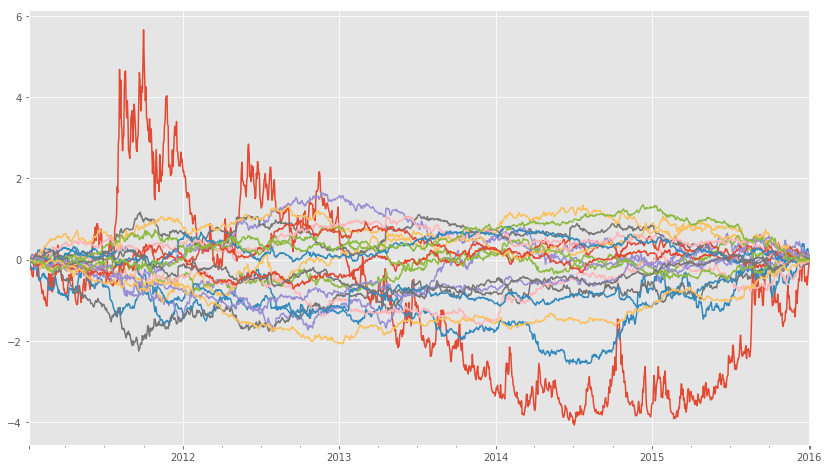

In [17]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

In [18]:
risk_model['factor_returns'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2011-01-07 00:00:00+00:00,-0.00057388,-0.03078079,0.01142833,-0.02387982,0.07440320,-0.06454955,0.00938615,-0.03285625,-0.04704520,-0.01592485,0.00651258,-0.08789323,-0.00068162,0.00711893,-0.02187250,0.00270914,0.01209078,-0.01534435,0.00931727,-0.03695989
2011-01-10 00:00:00+00:00,-0.00333759,-0.02950323,0.06390789,-0.00317003,-0.04002591,-0.06226292,-0.00242112,0.00256980,0.03989263,-0.05488101,0.03783253,0.04242994,-0.00938544,0.00310780,-0.03170928,-0.02842235,-0.00720006,0.02907215,-0.00564516,-0.00027511
2011-01-11 00:00:00+00:00,-0.06936844,-0.08921570,-0.02204543,-0.00942052,0.00505149,0.07003570,0.00943421,0.00903264,-0.00264150,0.05637489,-0.04561047,-0.01326765,-0.00294858,0.00714818,-0.00556709,-0.03076678,0.06644666,0.02196610,-0.03633055,-0.00855382
2011-01-12 00:00:00+00:00,-0.17364190,-0.04105645,-0.00725755,0.04069695,-0.00404125,-0.00726571,0.04697501,0.02430742,0.03559512,0.00598710,0.02007335,-0.00082699,-0.00413046,0.00101740,-0.00591098,0.01342827,-0.00491880,-0.01818481,0.01916597,0.00962232
2011-01-13 00:00:00+00:00,0.03479996,0.00393971,0.02337029,-0.03462880,0.01852595,0.01027840,0.02553070,-0.01272686,0.02879092,-0.01126138,0.00445847,0.00959925,0.00948808,0.00806228,-0.00541915,-0.01072331,0.02818037,0.00463698,0.00081729,-0.00683069


## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [19]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)


project_tests.test_factor_cov_matrix(factor_cov_matrix)

Tests Passed


### View Data

In [20]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

#risk_model['factor_cov_matrix']

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [21]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)


project_tests.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

Tests Passed


### View Data

In [22]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.02272535,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.05190083,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05431181,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04801884,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03040361,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [23]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
   
    return pd.DataFrame(np.diag(idiosyncratic_var_matrix), index=idiosyncratic_var_matrix.index)


project_tests.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

Tests Passed


### View Data

In [24]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model.keys()

dict_keys(['factor_betas', 'factor_returns', 'factor_cov_matrix', 'idiosyncratic_var_matrix', 'idiosyncratic_var_vector'])

## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [25]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    p_risk = np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights))
    
    return p_risk.values[0][0]
    


project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

Tests Passed


### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [26]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16094824687040474

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [27]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def momentum_1yr_smoothed(window_length, universe, sector):
    
    unsmoothed = momentum_1yr(window_length, universe, sector)
    return SimpleMovingAverage(inputs=[unsmoothed], window_length=window_length).rank().zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [28]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    return - (Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore())
    


project_tests.test_mean_reversion_5day_sector_neutral(mean_reversion_5day_sector_neutral)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [29]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date).head()

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482
                          Equity(1 [AAL])                           1.62630815
                          Equity(2 [AAP])                           0.64906469
                          Equity(3 [AAPL])                          1.40752230
                          Equity(4 [ABBV])                          1.45857233

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [30]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    unsmoothed  = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    
    return (SimpleMovingAverage(inputs=[unsmoothed], window_length=window_length).rank().zscore())


project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral_smoothed(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the smoothed data looks like.

In [31]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date).head()

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784
                          Equity(1 [AAL])                                    1.72840822
                          Equity(2 [AAP])                                    1.34188655
                          Equity(3 [AAPL])                                   0.91160771
                          Equity(4 [ABBV])                                   0.96265774

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [32]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [33]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [34]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
# pipeline.add(
#     momentum_1yr_smoothed(252,universe,sector),
#     'Momentum_1YR_Smoothed')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(2 [AAP])                    -0.62687332  
                          Equity(3 [AAPL])                    0.53990823  
                          Equity(4 [ABBV])                   -0.06160027

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [35]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [36]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

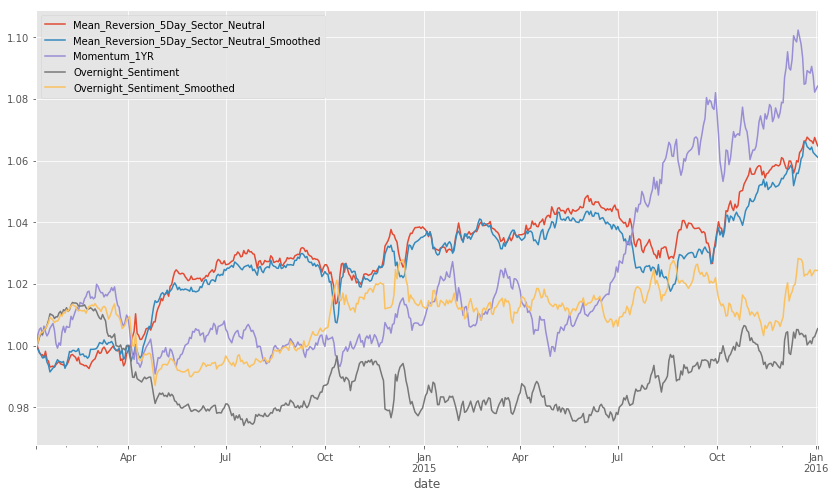

In [37]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feafe3862e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feafe385588>]], dtype=object)

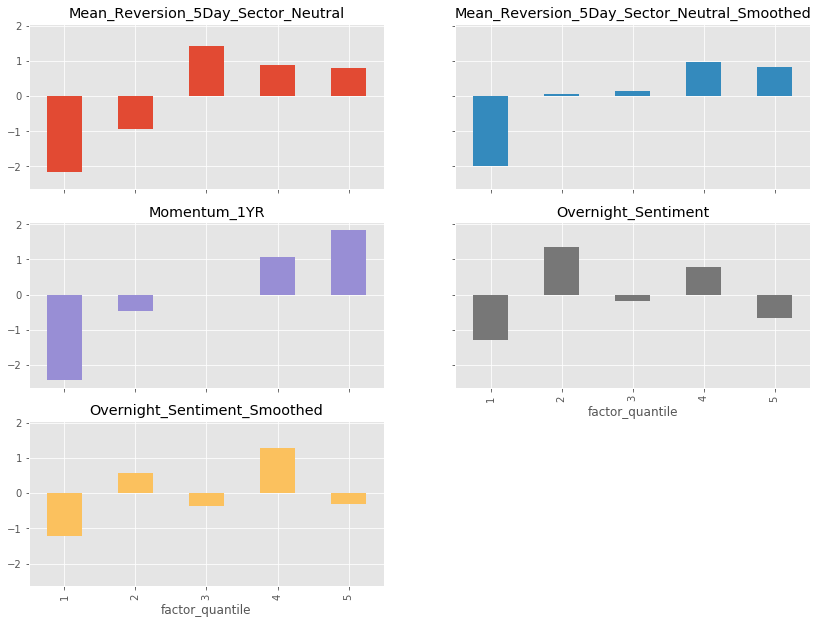

In [38]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

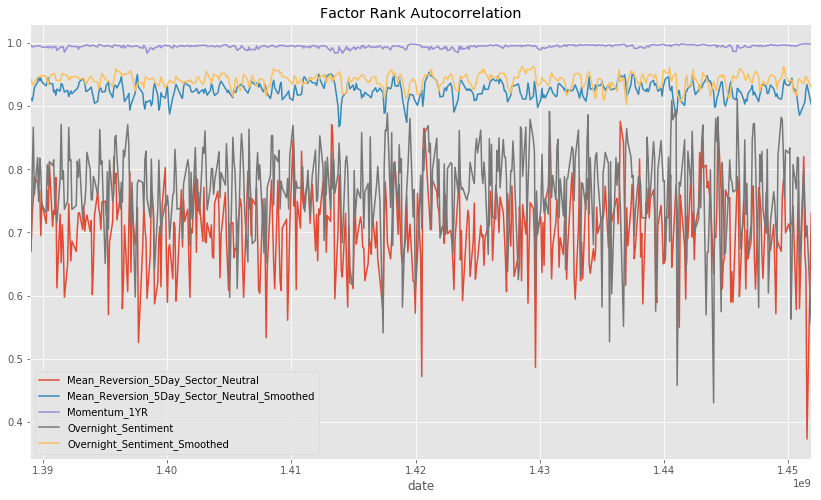

In [39]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [40]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    
    return (factor_returns.mean()/factor_returns.std()) * annualization_factor


project_tests.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [41]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            1.37000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   1.27000000
Momentum_1YR                                  1.13000000
Overnight_Sentiment                           0.12000000
Overnight_Sentiment_Smoothed                  0.45000000
dtype: float64

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

_#TODO: Put Answer In this Cell_

**Answer:** 
I have implemented this smoothing of the Momentum factor and from the output above, presuming I implemented it properly in the pipeline, we can see that our Sharpe ratio has declined. From the factor returns chart, we can see that it does not perform as well as the non-smoothed factor. In our quantiles analysis, we do not have montonic increases through the quantiles but there seem to be return in the top quantile than the lower, which may make it easier since we don't have to short as much to get the return and as indicated early, finding the shorts can be tough.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [42]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
Equity(0 [A]),-0.58642457
Equity(1 [AAL]),-0.45333845
Equity(2 [AAP]),-0.69993898
Equity(3 [AAPL]),-0.06790952
Equity(4 [ABBV]),-1.21617871


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [100]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [103]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        alpha_vector = np.asarray(alpha_vector)
#         print(alpha_vector)
      
        return cvx.Minimize(-1*weights*alpha_vector)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        

        
        constraints = []
        #constraint 1
        constraints.append(risk <= self.risk_cap**2)
        #constraint 2
        constraints.append(weights*factor_betas >= self.factor_min)
        #constraint 3
        constraints.append(weights*factor_betas <= self.factor_max)
        #constraint 4
        constraints.append(sum(weights) == 0)
        #constraint 5
        constraints.append(cvx.norm(weights, 1) <= 1.0)
        #constraint 6
        constraints.append(weights >= self.weights_min)
        #constraint 7
        constraints.append(weights <= self.weights_max)
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()



AssertionError: Wrong value for solve_problem.

INPUT weights:
var1228

OUTPUT solution:
[-0.01095357  0.00275944  0.02684855 -0.01865396]

EXPECTED OUTPUT FOR solution:
[-0.01095332  0.00275889  0.02684955 -0.01865511]


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


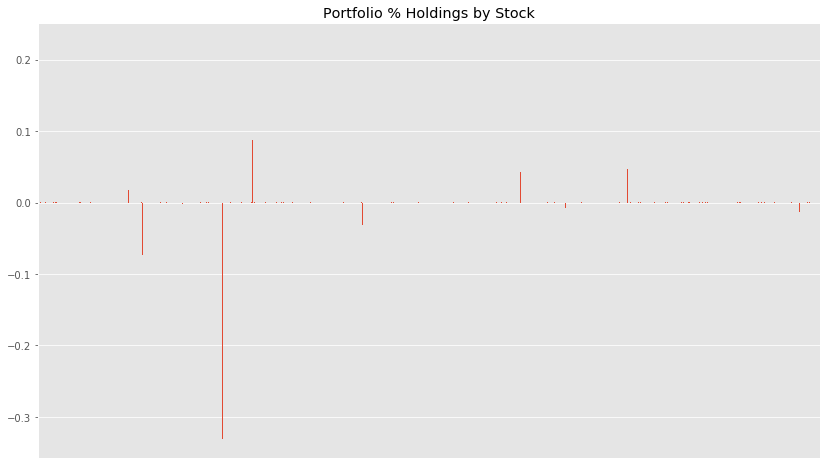

In [104]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

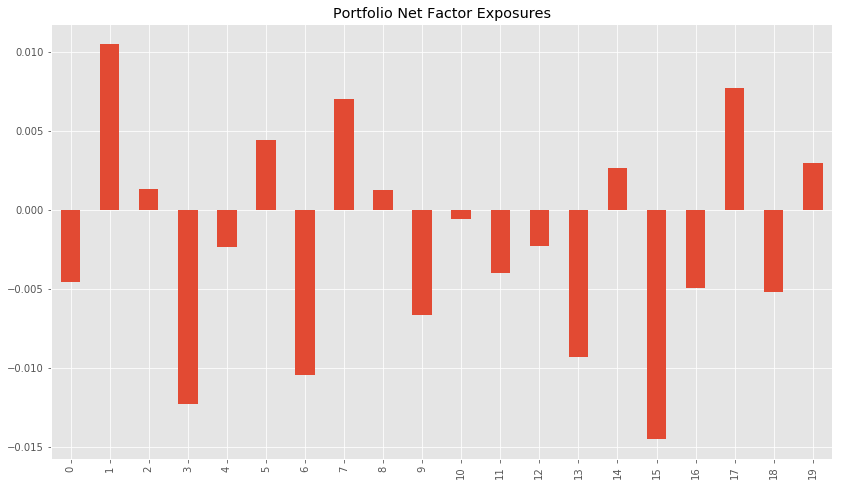

In [105]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [106]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        alpha_vector = np.asarray(alpha_vector)
        
        return cvx.Minimize(-(alpha_vector.T*weights) + self.lambda_reg*cvx.norm(weights, 2))

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


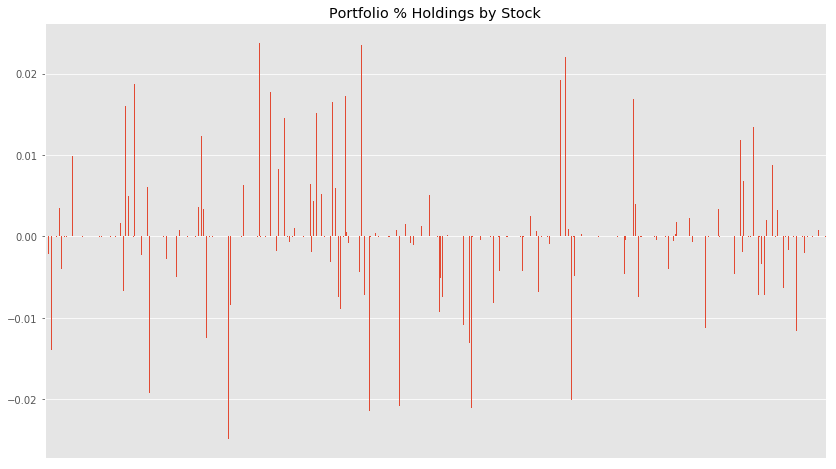

In [107]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

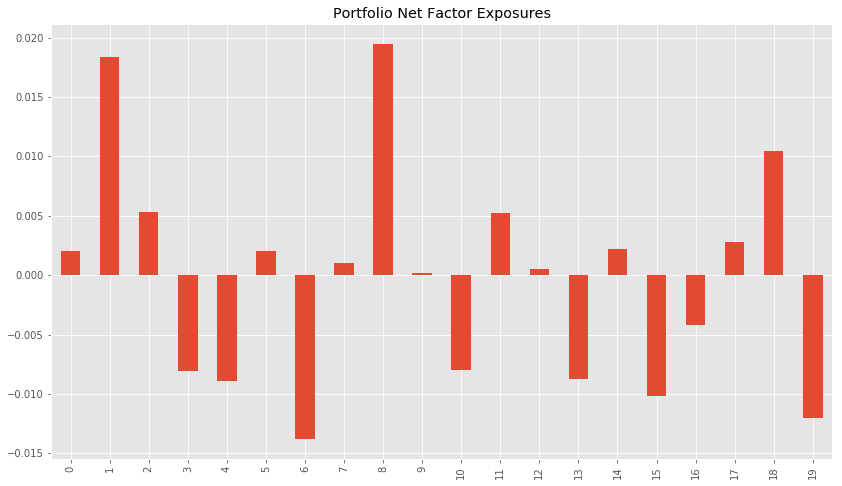

In [108]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [136]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        alpha_vector = np.asarray(alpha_vector)
        x_star = ((alpha_vector - alpha_vector.mean())/abs(alpha_vector).sum()).reshape(-1)
        obj = cvx.Minimize(cvx.norm(weights - x_star))
        return obj


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


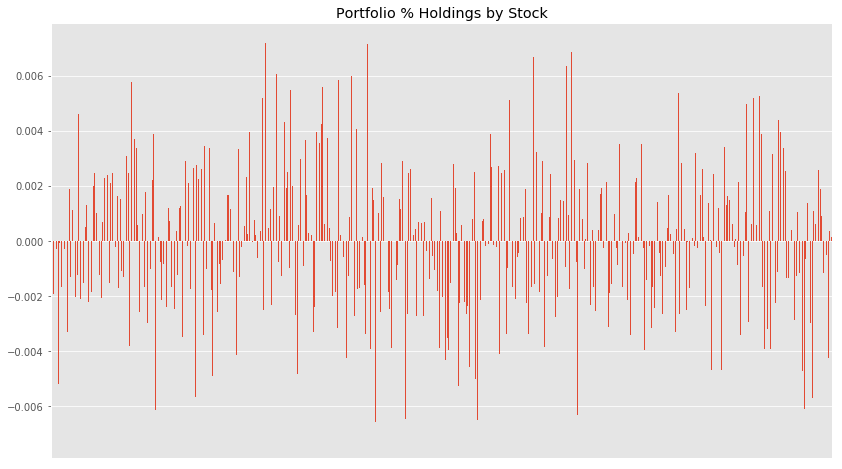

In [137]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

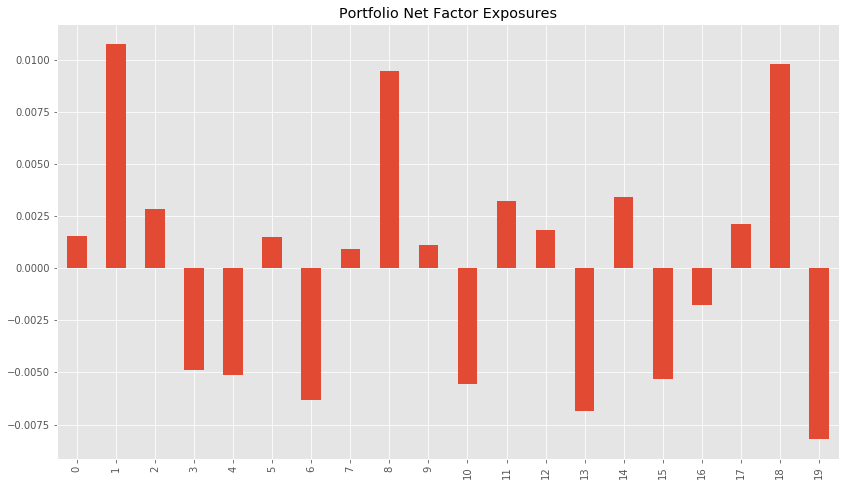

In [138]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.